# 使用1维卷积做滑坡敏感性制图（万州）

In [32]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score,f1_score,precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
import keras
from keras.models import Sequential
from keras.layers.core import Dense,Dropout,Activation
from keras.optimizers import SGD,Adam
from keras.utils import np_utils
from keras.utils import plot_model,print_summary
from keras.layers import Conv1D,MaxPooling2D,Flatten,Softmax,Activation,Dense
import matplotlib.pyplot as plt

In [2]:
data=np.genfromtxt('wanzhouLandslides.csv', delimiter=',',skip_header=1)

In [3]:
print(data.shape)

(582485, 31)


In [4]:
# 29列特征+1列标签+1个GeoID
X = data[:,0:29]
Y = data[:,29]
# print(X[0])
# print(Y[0:10])

[2.95000e+02 7.75467e+00 2.84931e+02 3.43289e+01 8.00000e+00 7.00315e-01
 2.73861e+00 5.08108e+00 5.26814e-01 3.34805e+01 6.79371e-01 7.30473e-02
 3.27524e-03 1.96984e-02 1.00000e+00 1.00000e+00 7.64735e+02 2.85000e+01
 5.91647e+01 4.57640e+00 6.55414e+00 8.79241e-02 2.54951e+00 1.58012e+02
 7.86250e-01 3.26397e-01 1.13447e+03 1.85445e+00 3.00000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [7]:
ss=StratifiedShuffleSplit(n_splits=2,test_size=0.3,random_state=23)#分成2组，测试比例为0.3

for train_index, test_index in ss.split(X, Y):
#     print("TRAIN_INDEX:", train_index, "TEST_INDEX:", test_index)#获得索引值
    x_train, x_test = X[train_index], X[test_index]#输入特征分割成2部分，训练部分和测试部分
    y_train, y_test = Y[train_index], Y[test_index]#类别集分割成2部分，训练部分和测试部分
#     print("x_train:",x_train)
#     print("y_train:",y_train)


x_train: [[ 526.        33.4561   324.728   ... 1177.58       1.39264    3.     ]
 [ 505.        13.2892   238.671   ... 1152.42       2.06307    3.     ]
 [ 376.        16.2667   222.563   ... 1155.5        2.01862    5.     ]
 ...
 [ 412.        24.0075    32.125   ... 1189.18       1.7329     5.     ]
 [ 265.         8.26168   64.9831  ... 1176.62       1.43333    5.     ]
 [ 382.        18.5653   319.236   ... 1154.37       2.02463    5.     ]]
y_train: [0. 0. 0. ... 0. 0. 0.]
x_train: [[ 344.         4.04531  277.125   ... 1191.29       1.7748     2.     ]
 [ 420.        19.6256   238.069   ... 1190.67       1.77468    3.     ]
 [ 486.         5.31552  315.      ... 1184.8        1.58503    3.     ]
 ...
 [ 269.         8.23935    1.7357  ... 1184.06       1.57878    5.     ]
 [ 206.        16.4603   174.036   ... 1160.12       2.03295    5.     ]
 [ 609.        23.205    318.318   ... 1177.18       1.38886    3.     ]]
y_train: [0. 0. 0. ... 0. 0. 0.]


In [8]:
print(y_train.shape)
print(y_test.shape)
print(x_train.shape)
print(x_test.shape)

(407739,)
(174746,)
(407739, 29)
(174746, 29)


In [10]:
# standardize train features
scaler = StandardScaler().fit(x_train)
scaled_train = scaler.transform(x_train)
scaler_test = StandardScaler().fit(x_test)
scaled_test = scaler_test.transform(x_test)

# 特征数量
nb_features = 29
# 2个类别: 滑坡与非滑坡
nb_class = 2

# reshape train data
X_train_r = np.zeros((len(x_train), nb_features, 1))
X_train_r[:, :, 0] = scaled_train[:, :nb_features]

# reshape test data
X_test_r = np.zeros((len(x_test), nb_features, 1))
X_test_r[:, :, 0] = scaled_test[:, :nb_features]

y_train_labels = np_utils.to_categorical(y_train, nb_class)
y_test_labels=np_utils.to_categorical(y_test,nb_class)


In [11]:
def plotROC(y_test_pred, y_test_label):
    Y_pred_0 = [y[1] for y in y_test_pred]  # 取出y中的一列
    Y_test_0 = [y[1] for y in y_test_label]
    fpr, tpr, thresholds_keras = roc_curve(Y_test_0, Y_pred_0)   
    auc_val = auc(fpr, tpr)
    print("AUC : ", auc_val)
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.3f})'.format(auc_val))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    #plt.savefig('results/ROC-curve.png', dpi=120)
    plt.show()

## case 1: conv1d->dropout->3个全连接

In [17]:
def case1(nb_features,X_train_r,y_train_labels, nb_epoch, nb_class=2 ):
    model = Sequential()
    model.add(Conv1D(filters=512, kernel_size=1, input_shape=(nb_features, 1)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(nb_class))
    model.add(Activation('softmax'))

#     sgd = SGD(lr=0.01, nesterov=True, decay=1e-6, momentum=0.9)
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

    nb_epoch = 10
    model.fit(X_train_r, y_train_labels, epochs=nb_epoch, batch_size=100)
    return model

m1 = case1(nb_features,X_train_r,y_train_labels,nb_epoch=20, nb_class=2 )

Epoch 1/10
407739/407739 [==============================] - 1313s 3ms/step - loss: 0.1387 - accuracy: 0.9507
Epoch 2/10
407739/407739 [==============================] - 1410s 3ms/step - loss: 0.1170 - accuracy: 0.9557
Epoch 3/10
407739/407739 [==============================] - 1392s 3ms/step - loss: 0.1025 - accuracy: 0.9604
Epoch 4/10
407739/407739 [==============================] - 1887s 5ms/step - loss: 0.0914 - accuracy: 0.9641
Epoch 5/10
407739/407739 [==============================] - 1347s 3ms/step - loss: 0.0834 - accuracy: 0.9670
Epoch 6/10
407739/407739 [==============================] - 1326s 3ms/step - loss: 0.0772 - accuracy: 0.9697
Epoch 7/10
407739/407739 [==============================] - 1690s 4ms/step - loss: 0.0715 - accuracy: 0.9719
Epoch 8/10
407739/407739 [==============================] - 1881s 5ms/step - loss: 0.0671 - accuracy: 0.9737
Epoch 9/10
407739/407739 [==============================] - 1834s 4ms/step - loss: 0.0637 - accuracy: 0.9752
Epoch 10/10
407739/

407739/407739 [==============================] - 157s 384us/step

TRAIN ACC : 0.9690978527069092
174746/174746 [==============================] - 45s 258us/step

TEST ACC : 0.9592437148094177

-------------------------------

AUC :  0.9837684140835383


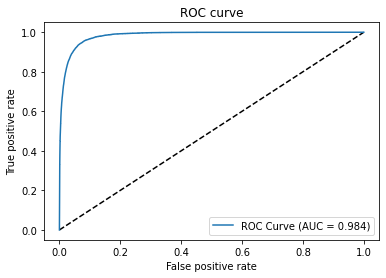

In [18]:
m1_result= m1.evaluate(X_train_r,y_train_labels,batch_size=100)
print('\nTRAIN ACC :',result[1])
m1_result_test= m1.evaluate(X_test_r,y_test_labels,batch_size=1000)
print('\nTEST ACC :',result_test[1])
print('\n-------------------------------\n')
m1_y_test_pred = m1.predict(X_test_r, batch_size=1000)
plotROC(m1_y_test_pred, y_test_labels)

In [20]:
#保存模型
m1.save('wanzhouM1.h5')

## case 2: 8个conv1d(kernel size =3 ) ->dropout->2个全连接

In [12]:
def case2(nb_features,X_train_r,y_train_labels, nb_epoch, nb_class=2 ):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, input_shape=(nb_features, 1)))
    model.add(Activation('relu'))
    for i in range(0,7):
        model.add(Conv1D(filters=64, kernel_size=3))
        model.add(Activation('relu'))
    model.add(Conv1D(filters=32, kernel_size=1))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nb_class))
    model.add(Activation('softmax'))

#     sgd = SGD(lr=0.01, nesterov=True, decay=1e-6, momentum=0.9)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

    model.fit(X_train_r, y_train_labels, epochs=nb_epoch, batch_size=1000)
    return model

m2 = case2(nb_features,X_train_r,y_train_labels,nb_epoch=20, nb_class=2 )

Epoch 1/20
407739/407739 [==============================] - 97s 238us/step - loss: 0.1706 - accuracy: 0.9486
Epoch 2/20
407739/407739 [==============================] - 91s 223us/step - loss: 0.1447 - accuracy: 0.9497
Epoch 3/20
407739/407739 [==============================] - 96s 235us/step - loss: 0.1406 - accuracy: 0.9496
Epoch 4/20
407739/407739 [==============================] - 92s 225us/step - loss: 0.1372 - accuracy: 0.9500
Epoch 5/20
407739/407739 [==============================] - 91s 222us/step - loss: 0.1338 - accuracy: 0.9504
Epoch 6/20
407739/407739 [==============================] - 93s 228us/step - loss: 0.1306 - accuracy: 0.9512
Epoch 7/20
407739/407739 [==============================] - 95s 234us/step - loss: 0.1273 - accuracy: 0.9520
Epoch 8/20
407739/407739 [==============================] - 93s 228us/step - loss: 0.1238 - accuracy: 0.9528
Epoch 9/20
407739/407739 [==============================] - 93s 227us/step - loss: 0.1199 - accuracy: 0.9542
Epoch 10/20
407739/

407739/407739 [==============================] - 44s 109us/step

TRAIN ACC : 0.9690978527069092
174746/174746 [==============================] - 10s 59us/step

TEST ACC : 0.9592437148094177

-------------------------------

AUC :  0.9512735641131926


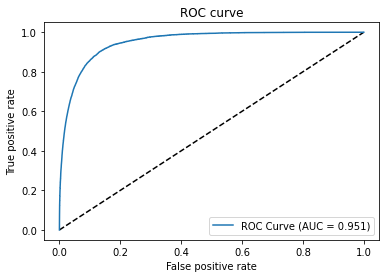

In [13]:
result= m2.evaluate(X_train_r,y_train_labels,batch_size=100)
print('\nTRAIN ACC :',result[1])
result_test= m2.evaluate(X_test_r,y_test_labels,batch_size=1000)
print('\nTEST ACC :',result_test[1])
print('\n-------------------------------\n')
y_test_pred = m2.predict(X_test_r, batch_size=100)
plotROC(y_test_pred, y_test_labels)

In [21]:
#保存模型
m2.save('wanzhouM2.h5')

In [1]:
# 绘制模型
# 请参考：https://github.com/Qinbf/plot_model
print_summary(m2)
# plot_model(m2)

NameError: name 'print_summary' is not defined